# Статистика, DS-поток
## Практическое задание 9. Критерии согласия

In [392]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot 
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.diagnostic import lilliefors
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'
alpha = 0.05

%matplotlib inline
sns.set(style='ticks', font_scale=1.7)

___
### Задача 1.

Вспомним недавнее тренировочное соревнование, задание 3.8, задача 3, в котором сравнивались ваши предсказания цены на жилье по имеющимся данным .

Возьмите предсказания вашей отправленной модели для тестовой выборки из соревнования (если не отсылали, то из задачи 2 того же задания). Для метрик MSE, MAE, MAPE постройте бутстрепные доверительные интервалы трех типов.

**Решение:**

In [201]:
target_predictions = pd.read_csv('./results.csv').price
test_target = pd.read_csv('./test_target.csv').price

In [202]:
mse = mean_squared_error(test_target, target_predictions)
mae = mean_absolute_error(test_target, target_predictions)
mape = mean_absolute_percentage_error(test_target, target_predictions)

*Находим бутстрепные статистики*

In [284]:
n = test_target.shape[0]
B = 10000
values = target_predictions

bootstrap_mses = [mean_squared_error(np.random.choice(values, n), test_target) for _ in range(B)]
bootstrap_maes = [mean_absolute_error(np.random.choice(values, n), test_target) for _ in range(B)]
bootstrap_mapes = [mean_absolute_percentage_error(np.random.choice(values, n), test_target) for _ in range(B)]

In [281]:
def normal_ci(bootstrap_stats, estimate):
    """Строит нормальный доверительный интервал."""
    z = sps.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = estimate - z * se, estimate + z * se
    return left, right

def central_ci(bootstrap_stats, estimate):
    """Строит центральный доверительный интервал."""
    left, right= 2 * estimate - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right

def quantile_ci(bootstrap_stats):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

In [285]:
normal_cis, central_cis, quantile_cis = [], [], []
metrics = [mse, mae, mape]
bootstrap_metrics = [bootstrap_mses, bootstrap_maes, bootstrap_mapes]

for metric, bootstrap_metric in zip(metrics, bootstrap_metrics):
    normal_cis.append(normal_ci(bootstrap_metric, metric))
    central_cis.append(central_ci(bootstrap_metric, metric))
    quantile_cis.append(quantile_ci(bootstrap_metric))

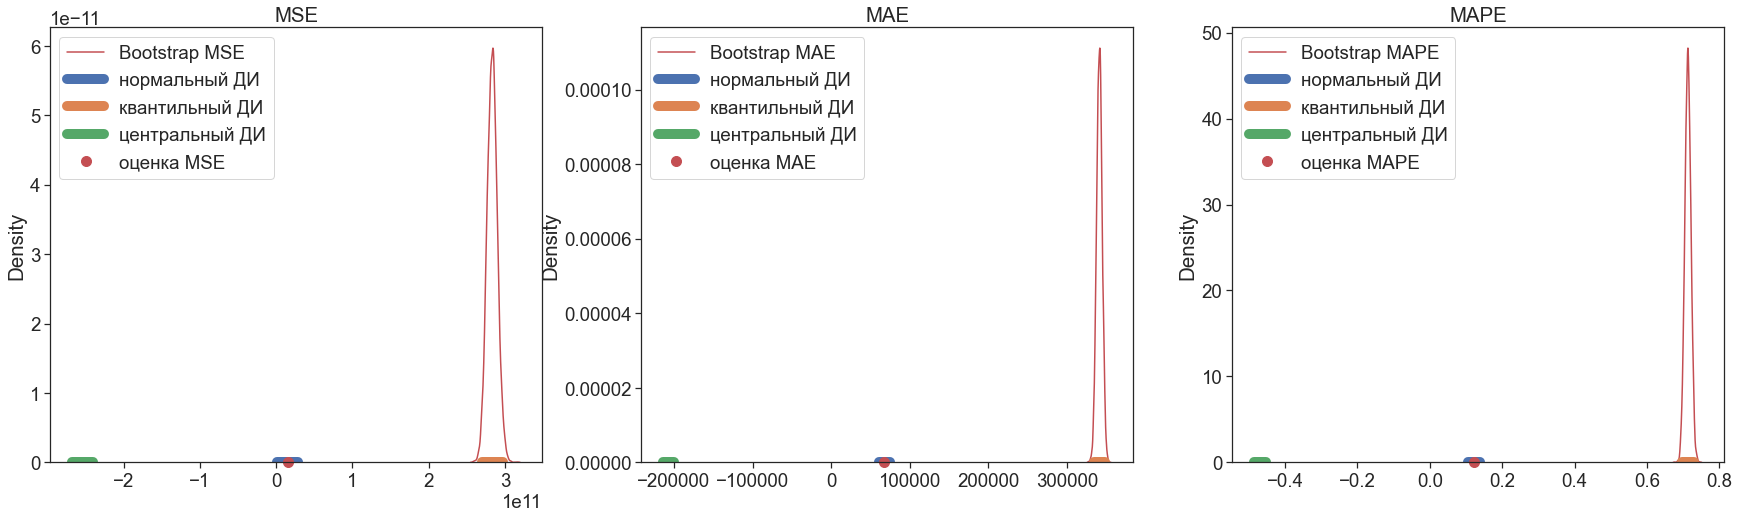

In [286]:
d = 0.01
fig, ax = plt.subplots(1, 3, figsize=(30, 8))
labels = ['MSE', 'MAE', 'MAPE']
for i in range(3):
    sns.kdeplot(bootstrap_metrics[i], ax=ax[i], c='r', label=f'Bootstrap {labels[i]}')
    ax[i].plot(normal_cis[i], [0, 0], label='нормальный ДИ', lw=10)
    ax[i].plot(quantile_cis[i], [0, 0], label='квантильный ДИ', lw=10)
    ax[i].plot(central_cis[i], [0, 0], label='центральный ДИ', lw=10)
    ax[i].plot([metrics[i]], [0], 'o', c='r', markersize=10, label=f'оценка {labels[i]}', clip_on=False)
    ax[i].legend()
    ax[i].set_title(labels[i]);

**Вывод:** *Видим, что распределение бутстрепных метрик близко к нормальному, поэтому нормальный ДИ во всех случаях покрывает оценку метрики. Остальные бутстрепные ДИ (центральные и квантильные) их не покрывают, так как они работают верно для несимметричных распределений статистик. Однако во всех 3х случаях оценка метрики лежит вне распределения бутсрепных метрик. Думаю это связано с тем, что бутстрепирование выборки сильно увеличивает ошибку между бутстрепным предсказанием и таргетом*  

___
### Задача 3.

Студенты периодически отправляют запросы в бот. Иногда бот бывает недоступен,
поэтому студенты с некоторыми интервалами повторяют запросы до тех пор, пока
бот не ответит. Известно, что $52$ запроса дошли с первой попытки, $31$ &mdash; со второй, $3$
&mdash; с третьей, а для доставки еще $5$ запросов потребовалось более $4$ попыток. Верно
ли, что бот получает запросы с вероятностью $\frac{2}{3}$?

**Решение:**

*1 способ*

*Попробуем смоделировать эксперимент. Расссмотрим случайную величину - номер первого успешного испытания в схеме Бернулли с заданной вероятностью успеха, то есть в данном случае номер первой успешной посылки. Такая величина имеет **геометрическое распределение**. Пусть параметр распределения p = 2/3. Размер данной выборки 52 + 31 + 3 + 5 = 91.*

In [22]:
p = 2/3
samples = sps.geom(p).rvs(size=(1000, 91))

In [17]:
p

0.6666666666666666

*Доли сообщений, дошедших с 1, 2, 3, 4 и более попыток соотвественно:*

In [65]:
np.hstack(((52/91), (31/91), (3/91), (5/91)))

array([0.57142857, 0.34065934, 0.03296703, 0.05494505])

In [39]:
unique = np.unique(samples, return_counts=True)
unique

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([60832, 20022,  6784,  2188,   807,   238,    92,    25,    10,
            2]))

In [62]:
one_to_tree_tries = unique[1][:3]
four_and_more_tries = np.array([unique[1][3:].sum()])
total = samples.shape[0] * samples.shape[1]

*Оценки доли сообщений, дошедших с 1, 2, 3, 4 и более попыток соотвественно:*

In [63]:
np.hstack((one_to_tree_tries, four_and_more_tries)) / total

array([0.66848352, 0.22002198, 0.07454945, 0.03694505])

*Доли отличаются от заданных, значит неверно что бот получает сообщения с вероятностью 2/3*

*2 способ: бутстреп*

In [72]:
n = 91
sample = [1]*52 + [2]*31 + [3]*3 + [4]*5

In [118]:
bootstrap_samples = np.array([np.random.choice(sample, size=n) for _ in range(1000)])

*Получим выборочное среднее:*

In [120]:
bootstrap_samples.mean(axis=1).mean()

1.570945054945055

*По свойству геометрического распределения: $E_x = 1/p$, значит $\widehat{p} = 1 / \overline{x}$*

In [122]:
p_estim = 1 / bootstrap_samples.mean(axis=1).mean()
p_estim

0.6365595008254288

*Оценка вероятности успеха отличается от заданной*

*В первых 2х способах получены оценки, и сделаны выводы, но нет степени уверенности в данных выводах, то есть на сколько должна отличаться оценка от реального параметра, чтобы говорить что предположение неверно. Для этого нужна проверка гипотез*

*3 способ: критерий согласия хи-квадрат*

*H0: распределение - Geom(2/3) vs H1: распределение - не Geom(2/3)*

In [124]:
sps.chisquare([52, 31, 3, 5])

Power_divergenceResult(statistic=71.59340659340658, pvalue=1.9454036234728723e-15)

*p-value < 0.05 => отвергаем H0. Хотя известно, что этот критерий применим при размере бакета >= 5, его применять некорректно. Применим Критерий колмогорова к той же паре гипотез:*

In [137]:
np.random.shuffle(sample)
sps.kstest(sample, sps.geom(p=2/3).cdf)

KstestResult(statistic=0.6666666666666666, pvalue=2.3332944673244494e-40)

***p-value < 0.05 => отвергаем H0***

**Вывод:** *Бот получает запросы с вероятностью НЕ 2/3, а какой-то другой. В целом можно было сразу использовать критерии, просто мне было интересно порассуждать, если в этом есть ошибки напишите пожалуйста. Так же, хотя в моем случае критерии дали одинаковый результат, надо следить за их применимостью.*

____
### Задача 4.

С помощью критерия хи-квадрат вам нужно проверить, правильно ли `scipy.stats` генерирует случайные величины. 

**1.** Реализуйте критерий для генерации выборки $U\{1, ..., 10\}$, аналогично разобранному на семинаре. Тем самым проверьте, что `sps.randint` действительно генерирует выборку из равномерного распределения.

<...>

**2.** Проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

**Указания**
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код в отдельной ячейке для *конкретной* реализации выборки. Так вам проще реализовать, а нам проще проверять.
**Решение:**

*1. Рассмотрим H0: $P = U\{1, .., 10\}$. Тут можно применять критерий хи-квадрат, так как средний размер бакета = 1000/ 10 = 100*

In [379]:
n = 1000
sample = sps.randint(1, 11).rvs(size=n)
unique_cnt = np.unique(sample, return_counts=True)
unique_cnt

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 92,  85, 106, 108, 116,  99, 104, 100,  94,  96]))

In [380]:
sps.chisquare(unique_cnt[1])

Power_divergenceResult(statistic=7.140000000000001, pvalue=0.6225460056339922)

*p-value > 0.05 => H0 не отвергается.*

*2. Рассмотрим аналогичную гипотезу. Проверим условие применимости критерия хи-квадрат*

In [384]:
sample = sps.poisson(mu=5).rvs(size=n)

In [385]:
unique_cnt = np.unique(sample, return_counts=True)
unique_cnt

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15]),
 array([  6,  34,  79, 148, 165, 160, 158, 104,  86,  33,  15,   6,   3,
          2,   1]))

*Видим, что последние 2 бакета содержат меньше 5 элеметов. Объединим 3 последних бакета в один, получим 12 бакетов*

In [386]:
unique_cnt_ok = unique_cnt[1][:11]
last_bucket = unique_cnt[1][11:].sum()
buckets = np.hstack((unique_cnt_ok, [last_bucket]))
buckets

array([  6,  34,  79, 148, 165, 160, 158, 104,  86,  33,  15,  12])

*Теперь также нужно передать ожидаемые частоты:* 

In [387]:
f_exp = sps.poisson(mu=5).pmf(np.arange(12)) * n
f_exp[-1] += sps.poisson(mu=5).sf(11) * n

In [389]:
sps.chisquare(buckets, f_exp)

Power_divergenceResult(statistic=11.383530925868696, pvalue=0.41171386916773456)

*p-value > 0.05 => H0 не отвергается.*

*Если бы не выполнили условие применимости:*

In [390]:
sps.chisquare(unique_cnt[1])

Power_divergenceResult(statistic=900.5299999999997, pvalue=3.324181244783821e-183)

**Вывод:** *В обоих случаях не отвергли гипотезу о том, что scipy действительно генерит заданные распределения с помощью критерия хи-квадрат. Также важно следить за его применимостью, так как если бы во втором примере не объединили последние бакеты, получили бы p-value < 0.05 и могли бы ошибочно отвергнуть гипотезу.*



__________________
### Задача 5.

На лекциях и семинарах были разобраны следующие критерии проверки нормальности:
* Колмогорова;
* Жарка-Бера;
* Шапиро-Уилка.

Cуществует модификация критерия Колмогорова для проверки нормальности — <a href="https://ru.wikipedia.org/wiki/Критерий_Лиллиефорса"> Критерий Лиллиефорса.</a> При решении задачи можете воспользоваться им, например, взяв реализацию из библиотеки `statsmodels`: <a href="https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.lilliefors.html">`statsmodels.stats.diagnostic.lilliefors`</a>, или же применять для конкретной $F_0$ критерий Колмогорова, пример использования которого можно найти в ноутбуке с лекции.

**1.** Данные критерии являются асимптотическими, и их реальное значение уровня значимости может отличаться от желаемого числа $\alpha=0.05$. На семинарах разобран метод оценки реального уровня значимости критерия. Посчитайте реальный уровень значимости этих критериев для размеров выборки от 5 до 100.

*Подсказка:*

In [ ]:
max_sample_size = ...
sample_count = ...
is_reject_<критерий> = np.zeros((max_sample_size, sample_count))

for i in tqdm(range(max_sample_size)):
    for j in range(sample_count):
        sample = ...
        is_reject_<критерий>[i, j] = ...

Ваша реализация:

In [393]:
sample_size_range = (5, 101)
sample_count = 10000
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(4)]
tests_name = ['Колмогорова', 'Жарка-Бера', 'Шапиро-Уилка', 'Лиллиефорса']
tests = [sps.kstest, sps.jarque_bera, sps.shapiro, lilliefors]

In [394]:
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(4)]

for i in tqdm(range(*sample_size_range)):
    for j in range(sample_count):
        sample = sps.norm.rvs(size=i)
        for k in range(4):
            if k == 0:
                res = tests[k](sample, cdf=sps.norm().cdf)
            else:
                res = tests[k](sample)
            is_reject[k][i, j] = res[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

In [395]:
alpha_real = [0]*4
for i in range(4):
    alpha_real[i] = is_reject[i].sum(axis=1) / sample_count
    alpha_real[i] = alpha_real[i][sample_size_range[0] : sample_size_range[1]]

Поясните, почему вы выбрали такое значение `sample_count`.

*Чем больше, тем лучше) Думаю можно теоретически вывести какой-то минимальный порог. Однако я взяла такое значение, которое достаточно большое но не будет считаться слишком долго*

Нарисуйте на одном графике зависимость реального уровня значимости от размера выборки для каждого критерия. Пунктиром отметьте уровень 0.05. Не забудьте добавить легенду и подписать оси.

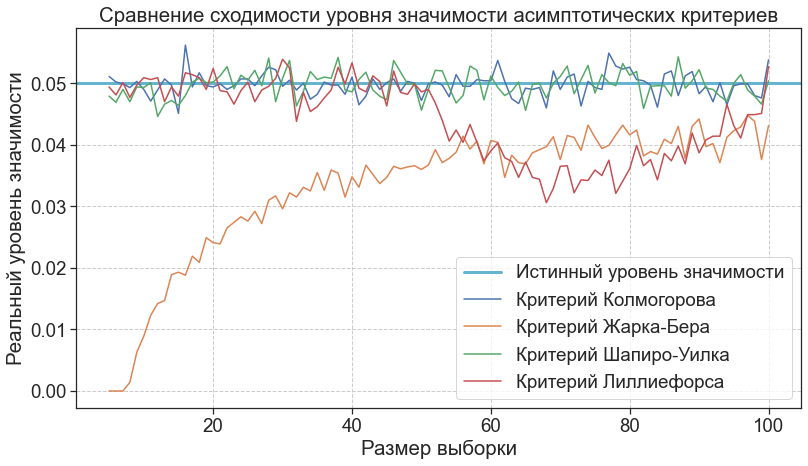

In [396]:
grid = np.arange(*sample_size_range)

plt.figure(figsize=(13, 7))
plt.axhline(alpha, color='c', lw=3, label='Истинный уровень значимости')

for ind, test in enumerate(tests_name):
    plt.plot(grid, alpha_real[ind], label='Критерий ' + test)
    
plt.title('Сравнение сходимости уровня значимости асимптотических критериев')
plt.xlabel('Размер выборки')
plt.ylabel('Реальный уровень значимости')
plt.grid(linestyle='--')
plt.legend();

Какой можно сделать вывод?

*Критерий Жарка-Бера даёт реальный уровень значимости меньший, чем асимптотический, в отличие от остальных критериев, которые не гарантируют уровень значимости при маленьком размере выборке.*

**2.** Аналогичным образом можно вычислять мощность критерия. Вычислите мощности критериев для размеров выборки от 5 до 100, если альтернативная гипотеза заключается в том, что выборка имеет стандартное распределение Коши. Иначе говоря, для критерия $S$ надо приближенно посчитать $\beta_S(\mathsf{P})$, где $\mathsf{P}$ — стандартное распределение Коши.

Нарисуйте на одном графике зависимость мощности критерия от размера выборки для каждого критерия. Не забудьте добавить легенду и подписать оси.


In [405]:
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(4)]
for i in tqdm(range(*sample_size_range)):
    for j in range(sample_count):
        sample = sps.cauchy().rvs(size=i)
        for k in range(4):
            if k == 0:
                res = tests[k](sample, cdf=sps.norm().cdf)
            else:
                res = tests[k](sample)
            is_reject[k][i, j] = res[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

In [406]:
power_real = [0]*4

for i in range(4):
    power_real[i] = is_reject[i].sum(axis=1) / sample_count
    power_real[i] = power_real[i][sample_size_range[0] : sample_size_range[1]]

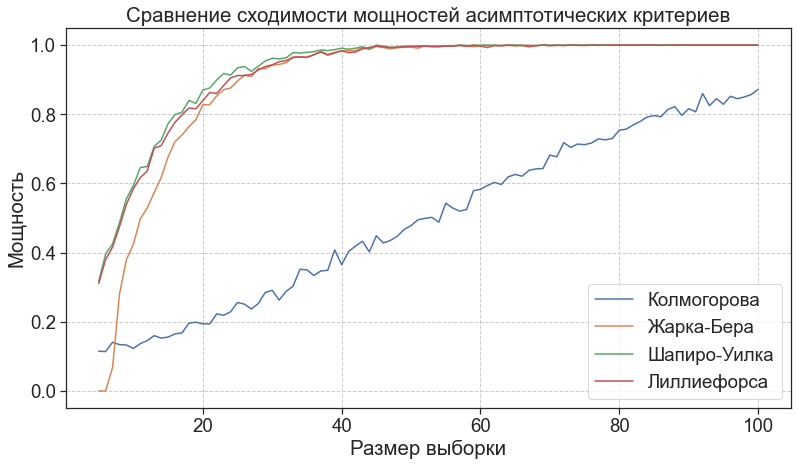

In [407]:
grid = np.arange(*sample_size_range)
plt.figure(figsize=(13, 7))

for i in range(4):
    plt.plot(grid, power_real[i], label=tests_name[i])

plt.grid(linestyle='--')
plt.title('Сравнение сходимости мощностей асимптотических критериев')
plt.xlabel('Размер выборки')
plt.ylabel('Мощность')
plt.legend();

Сделайте вывод. Какой критерий является наиболее мощным при данной альтернативе?

*Можно заметить, что в этом случае наибольшую мощность даёт критерий Колмогорова. Но в любом случае, нет универсально лучшего критерия, и для разных альтернатив нужно выбирать подходящий.*

**3.** Распределение Стьюдента является в некотором смысле обобщением нормального распределения (при бесконечном количестве степеней свободы) и распределения Коши (при одной степени свободы). 
Посчитайте приближенно мощности критериев для выборки размера 50 если альтернатива заключается в том, что выборка имеет распределение Стьюдента. Поскольку мощность критерия является функцией от распределения из альтернативной гипотезы, вам нужно посчитать функцию. Посчитайте её значения для целых значений степени свободы от 1 до 10.

Нарисуйте на одном графике зависимость мощности критерия от количества степеней свободы для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [ ]:
<...>

Сделайте вывод относительно мощности критерия при разных распределениях из альтернативы.

<...>

**4.** Аналогичным образом посчитайте мощности критериев, если альтернативная гипотеза заключается в том, что выборка имеет экспоненциальное распределение. Постройте график зависимости мощности от параметра альтернативной гипотезы.

In [ ]:
<...>

Сделайте вывод:

<...>

___________
### Задача 6.

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`. В дальнейшем будем называть колонки признаками.

In [397]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
columns = [ 'Alcohol',
                 'Malic acid',
                 'Ash',
                 'Alcalinity of ash',
                 'Magnesium',
                 'Total phenols',
                 'Flavanoids',
                 'Nonflavanoid phenols',
                 'Proanthocyanins',
                 'Color intensity',
                 'Hue',
                 'OD280/OD315 of diluted wines',
                 'Proline']

df = pd.read_csv(url, names=columns).reset_index(drop=True)
df.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Для каждого из признаков нарисуйте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

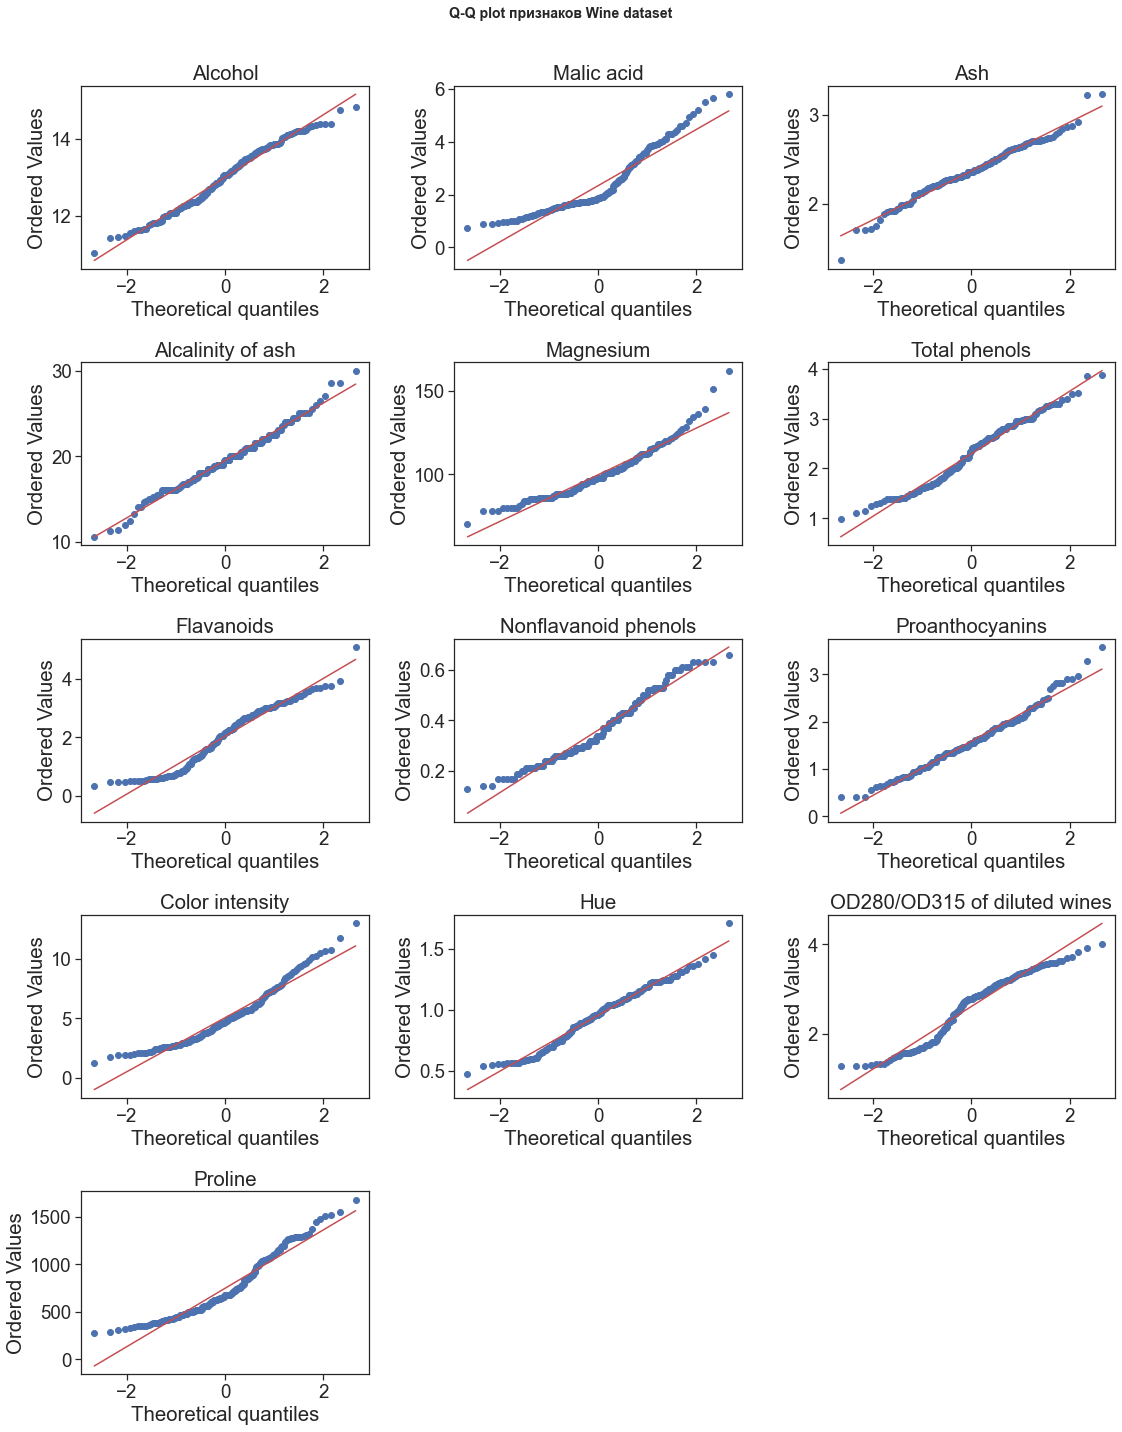

In [399]:
plt.figure(figsize=(16, 20))

for i, name in enumerate(columns):
    plt.subplot(5, 3, i + 1)
    sps.probplot(x=df[name], dist='norm', fit=True, plot=plt)
    plt.title(name)

plt.suptitle('Q-Q plot признаков Wine dataset', y=1, fontweight='bold', fontsize=14)
plt.tight_layout();

Для каких признаков можно говорить об их нормальности и почему?

**Ответ:** *На глаз достаточно сложно сравнивать, но в целом видно, что выборочные квантили параметров **Alcohol, Ash, Alcanity of ash, Proanthocyanins и Hue** довольно хорошо ложатся на прямую, значит скорее всего имеют нормальное распределение.*

Проверьте нормальность каждого признака статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы. Помочь в этом может теоретическое домашнее задание 10.

Для каждого признака используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** *Основные критерии - это 3 первых из предыдущего задания. Но для применения критерия Колмогорова нужно знать параметры распределения, поэтому буду использовать критерии Жарка-Бера и Шапиро-Уилка.*

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех признаков и всех критериев сразу. Почему так нужно делать?

**Ответ:** *Чтобы вероятность отклонить хотя бы одну верную гипотезу о нормальности распределения, то есть допущения хотя бы одной ошибки 1 рода, была <= 5. При объединении результатов значение ошибки может увеличиться*

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** *Так как мы ничего не знаем о зависимости между признаками, то стоит применять метод Холма, так как он самый мощный при возможной зависимости распределений.*

Как понять из результата процедуры множественной проверки гипотез, нормальность каких признаков следует отклонить?

**Ответ:** *Пусть H0: нормальность распределения параметра. Для всех параметров, у которых скорректированный p-value >  𝛼  хотя бы у одного критерия, отвергаем нулевую гипотезу.*

Если нормальность не отклоняется, что можно сказать про выборку? Ответ находится в презентации с лекции.

**Ответ:** *В таком случае говорят, что выборка согласуется с основной гипотезой, а значит предположительно нормально распределена.*

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результаты соберите обратно в таблицу с помощью метода `reshape`, которому необходимо передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия признаков, а названий столбцов — используемые критерии. В таблице должны присутстововать как значения p-value, так и результат проверки (`True` в случае отвержения).

In [400]:
shapiro = df.apply(sps.shapiro).iloc[1, :]
jarque_bera = df.apply(sps.jarque_bera).iloc[1, :]
crits = pd.DataFrame()
crits['Жарка-Бера'] = jarque_bera
crits['Шапиро'] = shapiro
crits

,Жарка-Бера,Шапиро
Alcohol,6.106775e-02,2.005172e-02
Malic acid,1.115426e-07,2.945930e-10
Ash,8.485917e-03,3.868526e-02
Alcalinity of ash,2.509338e-01,2.638694e-01
Magnesium,6.883383e-15,6.345416e-07
Total phenols,6.312188e-02,4.395752e-03
Flavanoids,5.273120e-02,1.679064e-05
Nonflavanoid phenols,1.071359e-02,1.055266e-04
Proanthocyanins,7.840977e-03,1.445338e-02
Color intensity,1.092262e-05,9.229477e-07


In [402]:
crits = multipletests(crits.values.ravel(), method='holm')[1]
crits = crits.reshape((-1, 2))
crits = pd.DataFrame(crits, columns=['Жарка-Бера', 'Шапиро'], index=columns)
rejected = crits <  0.05
rejected

,Жарка-Бера,Шапиро
Alcohol,False,False
Malic acid,True,True
Ash,False,False
Alcalinity of ash,False,False
Magnesium,True,True
Total phenols,False,False
Flavanoids,False,True
Nonflavanoid phenols,False,True
Proanthocyanins,False,False
Color intensity,True,True


*Оставляем только те признаки, нормальность которых не отвергаются критериями*

In [403]:
rejected.loc[(rejected['Жарка-Бера'] == False) & (rejected['Шапиро'] == False)]

,Жарка-Бера,Шапиро
Alcohol,False,False
Ash,False,False
Alcalinity of ash,False,False
Total phenols,False,False
Proanthocyanins,False,False
Hue,False,False


Для каких признаков нормальность не отвергается?

**Ответ:** *Получили, что помимо  Alcohol, Ash, Alcanity of ash, Proanthocyanins и Hue, нормальность не отвергается и для параметра Total phenols.*

**Вывод:** *Визуально по Q-Q plot определить нормальность признаков возможно, но совсем не точно. Часть признаков, которые я предположила, действительно оказались нормальными, но после МПГ увидели, что еще один признак - Total phenols. То есть благодаря МПГ мы уменьшаем вароятность ошибки 1 рода.*